### Problem - Predict will it rain tomorrow or not using Australia rainfall dataset
Build a model to predict whether it is going to rain tomorrow or not on the basis of Different waether features provide. 

### Dataset Information :
There are 145460 rows and 23 attributes for each row of the dataset.

### Solution
Create a model which will predict wether it will rain next day or not using given weather details. 

### Imports all the required libraries 

In [522]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [523]:
# Loading the dataset
df_weather = pd.read_csv('weatherAUS.csv')

#As the coulmn RISK_MM is highly co-related and of no use, we will drop it from the data-frame.
df_weather = df_weather.drop('RISK_MM', axis = 1)

df_weather.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# Exploratory Data Analysis

In [524]:
# The size of dataframe
df_weather.shape

(145460, 23)

### Dataframe Info & Summary:

In [525]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

According to above observation:
- The `Date` column needs converted from Character datatype to a datetime datatype
- Rest of the features looks fine.
- We can notice their are large amount of data are missing values for many columns, which is needed to handled.

In [526]:
# Lets find out how many missing values per column as well as in percentage too:
missing_val = df_weather.isnull().sum().sort_values(ascending = False)
percentage_of_missing_val = (missing_val/len(df_weather))*100
pd.concat([missing_val, percentage_of_missing_val], axis = 1, keys= ['Missing Values', '% Missing Value'])

,Missing Values,% Missing Value
Sunshine,69835,48.009762
Evaporation,62790,43.166506
Cloud3pm,59358,40.807095
Cloud9am,55888,38.421559
Pressure9am,15065,10.356799
Pressure3pm,15028,10.331363
WindDir9am,10566,7.263853
WindGustDir,10326,7.098859
WindGustSpeed,10263,7.055548
Humidity3pm,4507,3.098446


According to above observation:
- Given 4 columns - `Evaporation`, `Sunshine`, `Cloud9am`, `Cloud3pm` have more than 38% of missing values.
- Most of the columns have at least some missing values. 
- Only 2 columns - `Date`, `Location` have no missing data.
 We can handle these missing values by either dropping certain columns/rows, replacing the null values.

In [527]:
# information about the data
df_weather.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


##### From above dataset inferential stats, we can notice that multiple columns have outliers values.

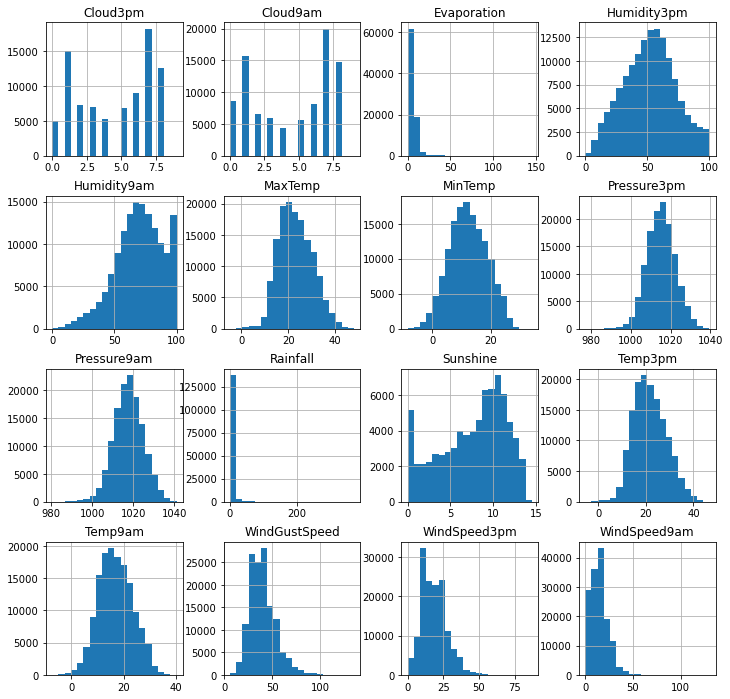

In [528]:
df_weather.hist(figsize=(12,12), bins=20)
plt.show()

According to above 2 observation:
- The `Rainfall` columns many large outlier which is needed to fixed.
- Most of the features looks normally distributed ,and for rest of the feature we will normalize then by performing scaling on dataset.

In [529]:
#Lets explore the column - Date :
df_weather.Date.value_counts()

2015-11-02    49
2013-06-06    49
2015-12-28    49
2014-11-27    49
2016-06-27    49
              ..
2008-01-25     1
2008-01-30     1
2007-12-09     1
2007-11-11     1
2007-11-29     1
Name: Date, Length: 3436, dtype: int64

In [530]:
#Lets find the count of different location
df_weather.Location.nunique()

49

##### Accoding to above observation, we can see that given date aligns with the number of different locations in the dataset. 

In [531]:
# Lets convert the column - RainToday into integer columns:
df_weather.RainToday = df_weather.RainToday.map({'No': 0, 'Yes': 1})
df_weather.RainToday.value_counts()

0.0    110319
1.0     31880
Name: RainToday, dtype: int64

In [532]:
# Lets convert the column - RainTomorrow into integer columns:
df_weather.RainTomorrow = df_weather.RainTomorrow.map({'No': 0, 'Yes': 1})
df_weather.RainTomorrow.value_counts()

0.0    110316
1.0     31877
Name: RainTomorrow, dtype: int64

In [533]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

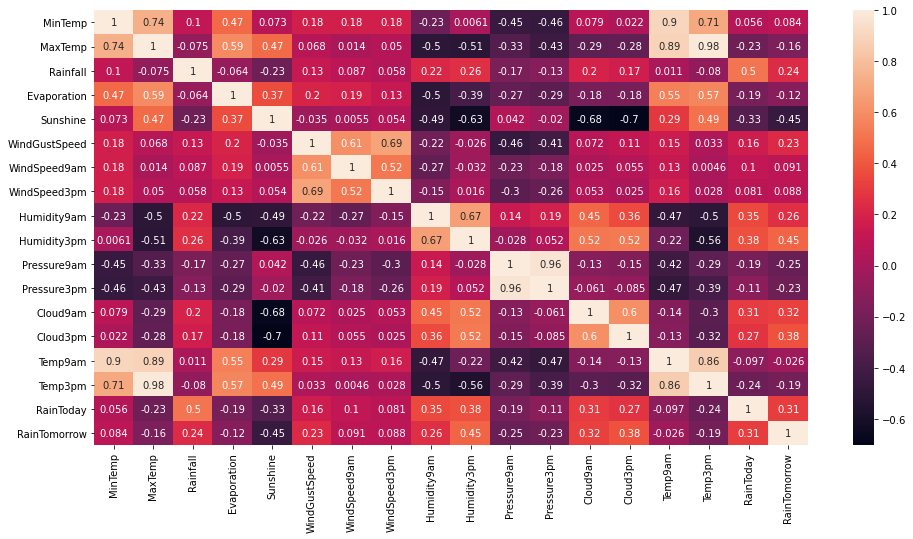

In [534]:
# Lets find the Co-relation between different features of the dataset
plt.figure(figsize = (16,8))
sns.heatmap(data = df_weather.corr(), annot = True)
plt.show()

In [535]:
# Lets check the count of observation for each location
df_weather.Location.value_counts()

Canberra            3436
Sydney              3344
Hobart              3193
Darwin              3193
Melbourne           3193
Perth               3193
Adelaide            3193
Brisbane            3193
Launceston          3040
Bendigo             3040
MountGinini         3040
Albury              3040
Cairns              3040
Townsville          3040
GoldCoast           3040
Wollongong          3040
Albany              3040
Ballarat            3040
MountGambier        3040
AliceSprings        3040
Tuggeranong         3039
Penrith             3039
Newcastle           3039
Mildura             3009
Witchcliffe         3009
WaggaWagga          3009
Dartmoor            3009
Cobar               3009
SydneyAirport       3009
BadgerysCreek       3009
Richmond            3009
Moree               3009
CoffsHarbour        3009
Nuriootpa           3009
PerthAirport        3009
Woomera             3009
PearceRAAF          3009
Sale                3009
Watsonia            3009
NorfolkIsland       3009


#### According to above observation, we can notice that the no. of observations per location is not same. 

#### Lets calculate Rainy Days for each Location

In [536]:
# Lets calculate the total no. of rainy days per location
df_rainy_day_by_loc = df_weather.groupby(by='Location').sum()
df_rainy_day_by_loc = df_rainy_day_by_loc[['RainToday']]
df_rainy_day_by_loc.head()

,RainToday
Location,
Adelaide,689.0
Albany,902.0
Albury,617.0
AliceSprings,244.0
BadgerysCreek,583.0


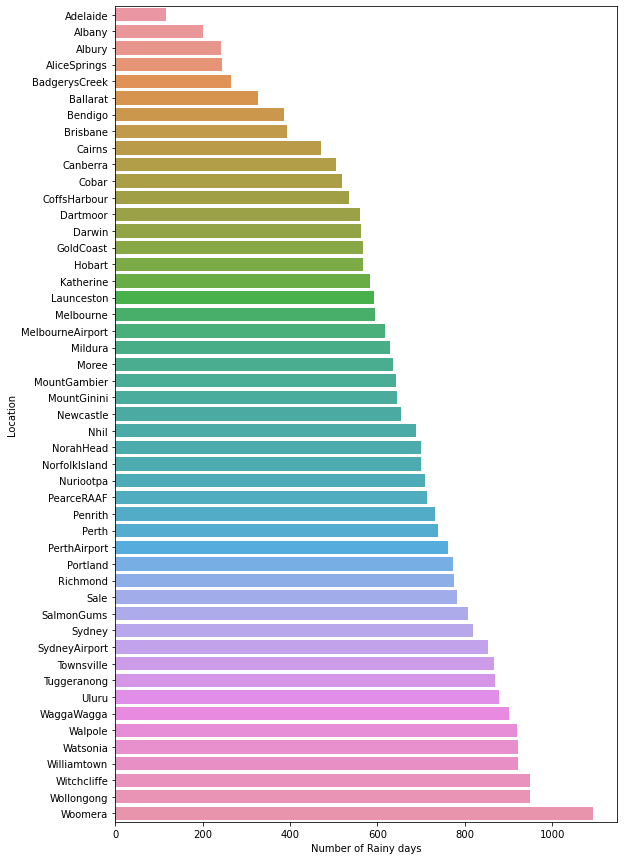

In [537]:
# using above dataframe, plot the barplot to understand the distribution 
plt.figure(figsize=(9, 15))
sns.barplot(data=df_rainy_day_by_loc.sort_values('RainToday'),x='RainToday', y=df_rainy_day_by_loc.index)
plt.xlabel('Number of Rainy days')
plt.show()

##### The above plot gives the information about number of rainy days for each locations. 

### Analysis of Seasonality and Trend pattern in the dataset
We knew that their exist a seasonality or trend patter regards rainy days with respect to time of the year.
Therefore, grouping the data by month of the year, we can get the percentage of days it rains in a each given month. 

In [538]:
#Lets extract the months info from each date
df_rain_seasonality = df_weather.copy()
df_rain_seasonality['month'] = df_rain_seasonality.Date.apply(lambda x: int(str(x)[5:7]))
df_rain_seasonality[['Date', 'month']].head()

,Date,month
0,2008-12-01,12
1,2008-12-02,12
2,2008-12-03,12
3,2008-12-04,12
4,2008-12-05,12


In [539]:
#Lets calculate the average rainy days with respect to months
df_rain_seasonality_group = df_rain_seasonality.groupby('month').mean()
df_rain_seasonality_group[['RainToday']]

,RainToday
month,
1,0.189484
2,0.206746
3,0.217135
4,0.216845
5,0.222163
6,0.263638
7,0.270736
8,0.253167
9,0.229135


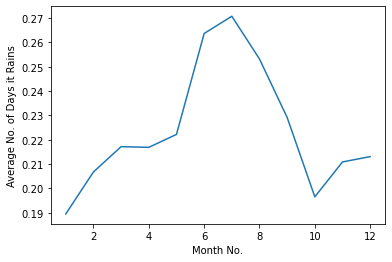

In [540]:
#Lets plot the line graph to understand the seasonality of rainy days with respect to given months
sns.lineplot(data=df_rain_seasonality_group, x=df_rain_seasonality_group.index, y='RainToday')
plt.xlabel('Month No.')
plt.ylabel('Average No. of Days it Rains')
plt.show()

##### From above plot, we can clearly notice a seasonality pattern exist for no. of Rainy days in each month .

#### Lets add feature - `Month`, by extracting it from Column - `Date` , and also notice that Date has no null values.
As no. of rainy days shows a seasonality pattern. It will be better to use column - `Month` than the date value from the `Date` column.

In [541]:
df_weather_month = df_weather.copy()
df_weather_month.insert(1, 'Month', df_weather_month.Date.apply(lambda x: int(str(x)[5:7])))
df_weather_month.drop(columns='Date', inplace=True)
df_weather_month.head()

,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,12,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0
1,12,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0
2,12,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0
3,12,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0.0
4,12,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0


# Data Preprocessing

### Lets handle missing Values:
we should not to replace null values for the target feature - `RainTomorrow`. 
As we don't know the future exact valuefor target feature, replacing null value for this column can effects our model. Therefore, we should drop rows in which the `RainTomorrow` value is null or missing.

In [542]:
df_missing = df_weather_month.dropna(axis=0, subset=['RainTomorrow'])
df_missing.isna().sum()

Month                0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64

In [543]:
# Size of the new dataframe with no target null value:
df_missing.shape

(142193, 23)

#### Handle missing value for continuous features

In [544]:
# we can use IterativeImputer for filling the missing value for continuous features
cont_feat = [col for col in df_missing.columns if df_missing[col].dtype != object]

# We will remove the column - 'RainTomorrow', Becasue it a dependent feature.
cont_feat.remove('RainTomorrow')

cont_feat

['Month',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday']

In [545]:
imputer = IterativeImputer(random_state=42)
df_weather_cont = imputer.fit_transform(df_missing[cont_feat])
df_weather_cont = pd.DataFrame(df_weather_cont, columns=cont_feat)
df_weather_cont.head()

,Month,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,12.0,13.4,22.9,0.6,6.754177,7.396118,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,5.013295,16.9,21.8,0.0
1,12.0,7.4,25.1,0.0,6.503240,11.067364,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,2.079171,2.640647,17.2,24.3,0.0
2,12.0,12.9,25.7,0.0,8.901058,12.018321,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,2.188729,2.000000,21.0,23.2,0.0
3,12.0,9.2,28.0,0.0,6.995448,11.745976,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,1.368168,1.991802,18.1,26.5,0.0
4,12.0,17.5,32.3,1.0,7.872282,6.022688,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0.0


In [547]:
# Now, we have no missing value for Continuous features.
df_weather_cont.isna().sum()

Month            0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
dtype: int64

#### Lets handle missing value for categorical features
We will replace the missing values with a randomly chosen unique values for each feature according to their probability distribution in given dataset.

In [548]:
categ_feat = [col for col in df_missing.columns if df_missing[col].dtype == object]

# Will remove column - Location, since they have no missing value
categ_feat.remove('Location')
categ_feat

['WindGustDir', 'WindDir9am', 'WindDir3pm']

In [549]:
df_weather_categ = df_missing[cat_feats]

for col in df_weather_categ.columns:
    values = df_weather_categ[col].value_counts().reset_index()['index'].values
    probs = df_weather_categ[col].value_counts(normalize=True).values
    df_weather_categ[col].replace(np.nan, np.random.choice(a=values, p=probs), inplace=True)

df_weather_categ.head()

,WindGustDir,WindDir9am,WindDir3pm
0,W,W,WNW
1,WNW,NNW,WSW
2,WSW,W,WSW
3,NE,SE,E
4,W,ENE,NW


In [550]:
# No missing value for given 3 categorical column
df_weather_categ.isna().sum()

WindGustDir    0
WindDir9am     0
WindDir3pm     0
dtype: int64

### Joining all the dataframe
After handling the missing values, we need to joined all the above dataframe and formed one dataframe for further processing.

In [551]:
print(df_missing['Location'].shape)
print(df_weather_cont.shape)
print(df_weather_categ.shape)
print(df_missing.RainTomorrow.shape)
df_weather_final = pd.concat(objs=[df_missing['Location'].reset_index(drop=True), 
                                   df_weather_cont.reset_index(drop=True), 
                                   df_weather_categ.reset_index(drop=True), 
                                   df_missing['RainTomorrow'].reset_index(drop=True)
                                  ], 
                             axis=1
                            )
print('--------------------------------')
print('final dataframe size',df_weather_final.shape)

(142193,)
(142193, 18)
(142193, 3)
(142193,)
--------------------------------
final dataframe size (142193, 23)


In [552]:
df_weather_final.head()

,Location,Month,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,WindGustDir,WindDir9am,WindDir3pm,RainTomorrow
0,Albury,12.0,13.4,22.9,0.6,6.754177,7.396118,44.0,20.0,24.0,...,1007.1,8.000000,5.013295,16.9,21.8,0.0,W,W,WNW,0.0
1,Albury,12.0,7.4,25.1,0.0,6.503240,11.067364,44.0,4.0,22.0,...,1007.8,2.079171,2.640647,17.2,24.3,0.0,WNW,NNW,WSW,0.0
2,Albury,12.0,12.9,25.7,0.0,8.901058,12.018321,46.0,19.0,26.0,...,1008.7,2.188729,2.000000,21.0,23.2,0.0,WSW,W,WSW,0.0
3,Albury,12.0,9.2,28.0,0.0,6.995448,11.745976,24.0,11.0,9.0,...,1012.8,1.368168,1.991802,18.1,26.5,0.0,NE,SE,E,0.0
4,Albury,12.0,17.5,32.3,1.0,7.872282,6.022688,41.0,7.0,20.0,...,1006.0,7.000000,8.000000,17.8,29.7,0.0,W,ENE,NW,0.0


In [553]:
# Lets check to that all the missing values have been handled:
df_weather_final.isna().sum()

Location         0
Month            0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
WindGustDir      0
WindDir9am       0
WindDir3pm       0
RainTomorrow     0
dtype: int64

### Convert into Dummy Variables using one-hot encoding
All the categorical features needs to be transformed into dummy variables inturn to be more useful in the modeling the algorithm.

In [554]:
categorical_features = ['Month', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
df_dummies_features = pd.get_dummies(df_weather_final, columns=categorical_features)
df_dummies_features.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,13.4,22.9,0.6,6.754177,7.396118,44.0,20.0,24.0,71.0,22.0,...,0,0,0,0,0,0,0,0,1,0
1,7.4,25.1,0.0,6.503240,11.067364,44.0,4.0,22.0,44.0,25.0,...,0,0,0,0,0,0,0,0,0,1
2,12.9,25.7,0.0,8.901058,12.018321,46.0,19.0,26.0,38.0,30.0,...,0,0,0,0,0,0,0,0,0,1
3,9.2,28.0,0.0,6.995448,11.745976,24.0,11.0,9.0,45.0,16.0,...,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,7.872282,6.022688,41.0,7.0,20.0,82.0,33.0,...,0,1,0,0,0,0,0,0,0,0


#### Spilt the final dataset as training and test set

In [555]:
df = df_dummies_features.copy()
X = df.drop(columns='RainTomorrow')
y = df.RainTomorrow

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=45)

print('Train-set size:', X_train.shape[0])
print('Test-set size: ', X_test.shape[0])

Train-set size: 106644
Test-set size:  35549


# Modelling - Predict whether it is going to rain tomorrow or not


## Logistic Regression

Model fitness
-------------------------
Train-set Score: 0.8424
Test-set Score: 0.8425
Accuracy: 84.2527




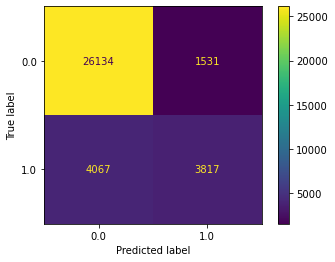

Classification report for Test dataset:
---------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     27665
         1.0       0.71      0.48      0.58      7884

    accuracy                           0.84     35549
   macro avg       0.79      0.71      0.74     35549
weighted avg       0.83      0.84      0.83     35549



In [556]:
log_reg = LogisticRegression(random_state=45)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# model fitness for both train and test dataset
print('Model fitness') 
print('-'*25)
log_reg_train = log_reg.score(X_train, y_train)
print('Train-set Score:', round(log_reg_train,4))
log_reg_test = log_reg.score(X_test, y_test)
print('Test-set Score:', round(log_reg_test,4))
print('Accuracy:', round(accuracy_score(y_test, y_pred)*100,4))
print('\n') 

#calculate Confusion Matrix
plot_confusion_matrix(log_reg, X_test, y_test)
plt.show()

print("Classification report for Test dataset:")
print('-'*57)
print(classification_report(y_test, y_pred))

###### According above observation: Logistic regression model has good performance but Recall is  low for days on which we predict it going be RainTomorrow (1.0).


### Hyperparameter Tuning

In [493]:
log_reg_params = {
    'C': [1, 1e8, 1e16],
    'fit_intercept': [True, False],
    'max_iter': [60, 120, 150],
    'random_state': [45]
}

log_reg_ht = GridSearchCV(logreg, logreg_params, scoring='accuracy', cv=5)
log_reg_ht.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [1, 100000000.0, 1e+16],
                         'fit_intercept': [True, False],
                         'max_iter': [50, 100, 150], 'random_state': [42]},
             scoring='accuracy')

In [494]:
log_reg_ht.best_params_

{'C': 100000000.0, 'fit_intercept': True, 'max_iter': 150, 'random_state': 42}

In [495]:
round(log_reg_ht.best_score_, 4)

0.8428

Model fitness
-------------------------
Train-set Score: 0.844
Test-set Score: 0.844
Accuracy: 84.391




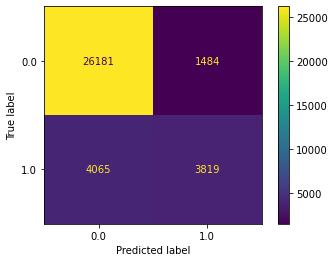

Classification report for Test dataset:
---------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.90     27665
         1.0       0.72      0.48      0.58      7884

    accuracy                           0.84     35549
   macro avg       0.79      0.72      0.74     35549
weighted avg       0.83      0.84      0.83     35549



In [496]:
y_pred = log_reg_ht.predict(X_test)

# model fitness for both train and test dataset
print('Model fitness') 
print('-'*25)
log_reg_ht_train = log_reg_ht.score(X_train, y_train)
print('Train-set Score:', round(log_reg_ht_train,3))
log_reg_ht_test = log_reg_ht.score(X_test, y_test)
print('Test-set Score:', round(log_reg_ht_test,3))
print('Accuracy:', round(accuracy_score(y_test, y_pred)*100,3))
print('\n') 


#calculate Confusion Matrix
plot_confusion_matrix(log_reg_ht, X_test, y_test)
plt.show()

print("Classification report for Test dataset:")
print('-'*57)
print(classification_report(y_test, y_pred))


###### According above observation: Slight more improvements in precision and fitness, but overall not much improvement in compare to the logistic regression model

## Decision Tree Classifier

Model fitness
-------------------------
Train-set Score: 1.0
Test-set Score: 0.788
Accuracy: 78.826




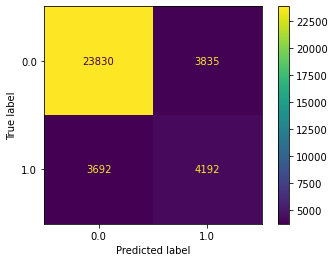

Classification report for Test dataset:
---------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86     27665
         1.0       0.52      0.53      0.53      7884

    accuracy                           0.79     35549
   macro avg       0.69      0.70      0.70     35549
weighted avg       0.79      0.79      0.79     35549



In [497]:
dtc = DecisionTreeClassifier(random_state=45)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

# model fitness for both train and test dataset
print('Model fitness') 
print('-'*25)
dtc_train = dtc.score(X_train, y_train)
print('Train-set Score:', round(dtc_train,3))
dtc_test = dtc.score(X_test, y_test)
print('Test-set Score:', round(dtc_test,3))
print('Accuracy:', round(accuracy_score(y_test, y_pred)*100,3))
print('\n') 


#calculate Confusion Matrix
plot_confusion_matrix(dtc, X_test, y_test)
plt.show()

print("Classification report for Test dataset:")
print('-'*57)
print(classification_report(y_test, y_pred))



###### According above observation: Accuracy of above model is less then the Logistic regression, and it also an overfit as it have have a Training-set fitness score to be 1.0

### Hyperparameter Tuning

In [498]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 7, 10],
    'min_samples_split': [3, 5, 7],
    'min_samples_leaf': [1, 2, 5],
    'random_state': [45]
}

dtc_ht = GridSearchCV(dtc, param_grid=params, scoring='accuracy', cv=3)
dtc_ht.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=45),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 10], 'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [3, 5, 7], 'random_state': [45]},
             scoring='accuracy')

In [499]:
dtc_ht.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'random_state': 45}

In [500]:
round(dtc_ht.best_score_, 4)

0.8418

Model fitness
-------------------------
Train-set Score: 0.8484
Test-set Score: 0.8402
Accuracy: 84.019




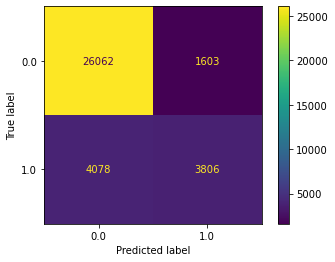

Classification report for Test dataset:
---------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     27665
         1.0       0.70      0.48      0.57      7884

    accuracy                           0.84     35549
   macro avg       0.78      0.71      0.74     35549
weighted avg       0.83      0.84      0.83     35549



In [502]:
y_pred = dtc_ht.best_estimator_.predict(X_test)

# model fitness for both train and test dataset
print('Model fitness') 
print('-'*25)
dtc_ht_train = dtc_ht.score(X_train, y_train)
print('Train-set Score:', round(dtc_ht_train,4))
dtc_ht_test = dtc_ht.score(X_test, y_test)
print('Test-set Score:', round(dtc_ht_test,4))
print('Accuracy:', round(accuracy_score(y_test, y_pred)*100,3))
print('\n') 


#calculate Confusion Matrix
plot_confusion_matrix(dtc_ht, X_test, y_test)
plt.show()

print("Classification report for Test dataset:")
print('-'*57)
print(classification_report(y_test, y_pred))

###### According above observation: Their is increase in the performances, and it also better fit than above models.

## Random Forest Classifier

Model fitness
-------------------------
Train-set Score: 1.0
Test-set Score: 0.8545
Accuracy: 85.445




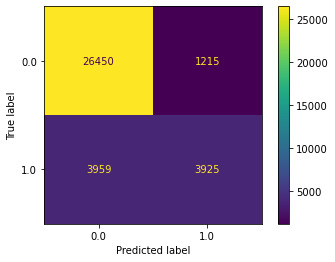

Classification report for Test dataset:
---------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     27665
         1.0       0.76      0.50      0.60      7884

    accuracy                           0.85     35549
   macro avg       0.82      0.73      0.76     35549
weighted avg       0.85      0.85      0.84     35549



In [503]:
rfc = RandomForestClassifier(random_state=45)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# model fitness for both train and test dataset
print('Model fitness') 
print('-'*25)
rfc_train = rfc.score(X_train, y_train)
print('Train-set Score:', round(rfc_train,4))
rfc_test = rfc.score(X_test, y_test)
print('Test-set Score:', round(rfc_test,4))
print('Accuracy:', round(accuracy_score(y_test, y_pred)*100,3))
print('\n') 

#calculate Confusion Matrix
plot_confusion_matrix(rfc, X_test, y_test)
plt.show()

print("Classification report for Test dataset:")
print('-'*57)
print(classification_report(y_test, y_pred))


###### According above observation: Their is more increase in the performances, but it is bit overfit than above models.

### Hyperparameter Tuning

In [ ]:
rfc_params = {
    'n_estimators': [12, 45, 80],
    'max_depth': [2, 6, 10],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [2, 5, 7],
    'random_state': [45]
}

rf_ht = GridSearchCV(rfc, rfc_params, scoring='accuracy', cv=3)
rf_ht.fit(X_train, y_train)

In [439]:
rf_ht.best_params_

{'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 45,
 'random_state': 45}

In [440]:
round(rf_ht.best_score_, 4)

0.8462

Model fitness
-------------------------
Train-set Score: 0.8551
Test-set Score: 0.8434
Accuracy: 84.337




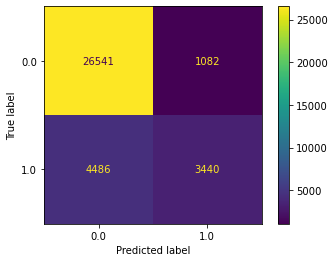

Classification report for Test dataset:
---------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91     27623
         1.0       0.76      0.43      0.55      7926

    accuracy                           0.84     35549
   macro avg       0.81      0.70      0.73     35549
weighted avg       0.83      0.84      0.83     35549



In [441]:
y_pred = rf_ht.best_estimator_.predict(X_test)

# model fitness for both train and test dataset
print('Model fitness') 
print('-'*25)
rf_ht_train = rf_ht.score(X_train, y_train)
print('Train-set Score:', round(rf_ht_train,4))
rf_ht_test = rf_ht.score(X_test, y_test)
print('Test-set Score:', round(rf_ht_test,4))
print('Accuracy:', round(accuracy_score(y_test, y_pred)*100,3))
print('\n') 


#calculate Confusion Matrix
plot_confusion_matrix(rf_ht, X_test, y_test)
plt.show()

print("Classification report for Test dataset:")
print('-'*57)
print(classification_report(y_test, y_pred))

According above observation: Accuracy is almost same but F1 score is decreased, and also it has better fit than above model.

## AdaBoost Classifier

Model fitness
-------------------------
Train-set Score: 0.847
Test-set Score: 0.8422
Accuracy: 84.219




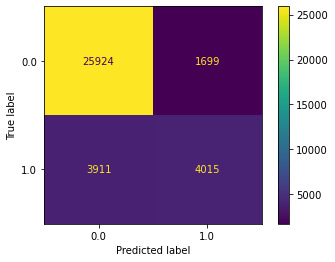

Classification report for Test dataset:
---------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     27623
         1.0       0.70      0.51      0.59      7926

    accuracy                           0.84     35549
   macro avg       0.79      0.72      0.75     35549
weighted avg       0.83      0.84      0.83     35549



In [442]:
abc = AdaBoostClassifier(random_state=45)
abc.fit(X_train, y_train)
y_pred = abc.predict(X_test)

# model fitness for both train and test dataset
print('Model fitness') 
print('-'*25)
abc_train = abc.score(X_train, y_train)
print('Train-set Score:', round(abc_train,4))
abc_test = abc.score(X_test, y_test)
print('Test-set Score:', round(abc_test,4))
print('Accuracy:', round(accuracy_score(y_test, y_pred)*100,3))
print('\n') 

#calculate Confusion Matrix
plot_confusion_matrix(abc, X_test, y_test)
plt.show()

print("Classification report for Test dataset:")
print('-'*57)
print(classification_report(y_test, y_pred))


According above observation: Accuracy is almost same, and also it has good fit like above model.

## Gradient Boosting Classifier

Model fitness
-------------------------
Train-set Score: 0.8546
Test-set Score: 0.8509
Accuracy: 85.091




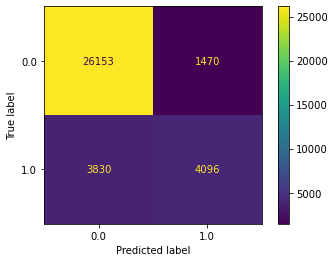

Classification report for Test dataset:
---------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91     27623
         1.0       0.74      0.52      0.61      7926

    accuracy                           0.85     35549
   macro avg       0.80      0.73      0.76     35549
weighted avg       0.84      0.85      0.84     35549



In [443]:
gbc = GradientBoostingClassifier(random_state=45)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

# model fitness for both train and test dataset
print('Model fitness') 
print('-'*25)
gbc_train = gbc.score(X_train, y_train)
print('Train-set Score:', round(gbc_train,4))
gbc_test = gbc.score(X_test, y_test)
print('Test-set Score:', round(gbc_test,4))
print('Accuracy:', round(accuracy_score(y_test, y_pred)*100,3))
print('\n') 

#calculate Confusion Matrix
plot_confusion_matrix(gbc, X_test, y_test)
plt.show()

print("Classification report for Test dataset:")
print('-'*57)
print(classification_report(y_test, y_pred))

###### According above observation: Their is  increase in the performances, it's fit the data also well.

## XGBoost Classifier

Model fitness
-------------------------
Train-set Score: 0.8908
Test-set Score: 0.8599
Accuracy: 85.988




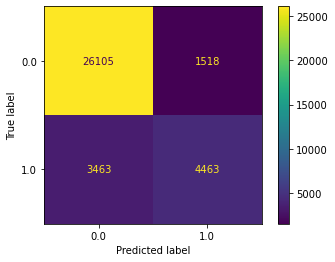

Classification report for Test data:
---------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     27623
         1.0       0.75      0.56      0.64      7926

    accuracy                           0.86     35549
   macro avg       0.81      0.75      0.78     35549
weighted avg       0.85      0.86      0.85     35549



In [444]:
xgbc = XGBClassifier(random_state=45,eval_metric='logloss')
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)

# model fitness for both train and test dataset
print('Model fitness') 
print('-'*25)
xgbc_train = xgbc.score(X_train, y_train)
print('Train-set Score:', round(xgbc_train,4))
xgbc_test = xgbc.score(X_test, y_test)
print('Test-set Score:', round(xgbc_test,4))
print('Accuracy:', round(accuracy_score(y_test, y_pred)*100,3))
print('\n') 

#calculate Confusion Matrix
plot_confusion_matrix(xgbc, X_test, y_test)
plt.show()

print("Classification report for Test data:")
print('-'*57)
print(classification_report(y_test, y_pred))

###### According above observation: Above model has highest accuracy score and best fit model for our dataset.

### Performance evaluation of Model

In [559]:
Perf_eval = {
    'model': ['Logistic Regression','Decision Tree','Random Forest','Adaboost',
              'Gradient Boosting ', 'XGBoost'],
    'Accuracy' : [84.391, 84.019, 85.445, 84.219, 85.091, 85.988],
}

eval_df = pd.DataFrame(data=Perf_eval)
eval_df.sort_values(by=['Accuracy'], ascending=False)

,model,Accuracy
5,XGBoost,85.988
2,Random Forest,85.445
4,Gradient Boosting,85.091
0,Logistic Regression,84.391
3,Adaboost,84.219
1,Decision Tree,84.019


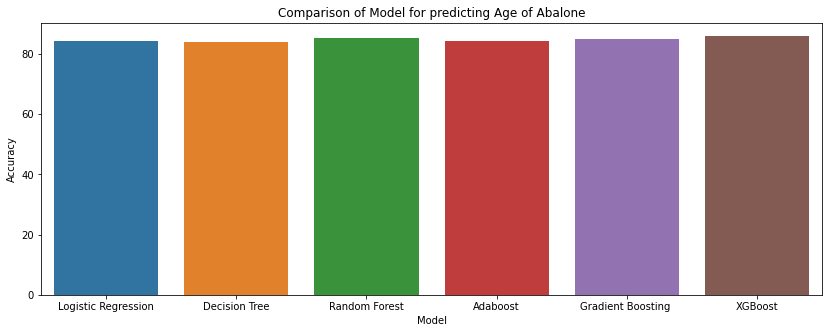

In [560]:
plt.figure(figsize=(14,5))
sns.barplot(x = eval_df['model'],
            y =eval_df['Accuracy'],
            data = eval_df
           )
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model for predicting Age of Abalone')
plt.show()